<a href="https://colab.research.google.com/github/lewinantao/Face_mask_detection/blob/master/Face_Mask_Detection_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face mask detection


In [ ]:
!pip install xmltodict --upgrade  # this will install xmltodict library

# importing  libraries
import cv2
import os
import random
import xmltodict

from PIL import Image
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import lxml.etree

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D

from tensorflow.keras.applications import EfficientNetB1, VGG19, ResNet50V2, InceptionV3, MobileNet,MobileNetV2, DenseNet201,Xception


from tensorflow.keras.layers import AveragePooling2D,Dropout,concatenate,Flatten,GlobalAveragePooling2D, Dense, Input,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns


import datetime
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Allocated GPU 

In [ ]:
!nvidia-smi

Fri Aug 20 16:39:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mounting Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset'
image_dir = os.path.join(base_dir, 'images/')
annot_dir = os.path.join(base_dir,'annotations/')

In [ ]:
print('Image Path      :',image_dir)
print('Annotation Path :',annot_dir)

Image Path      : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/images/
Annotation Path : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/annotations/


In [ ]:
train_dir = os.path.join(base_dir, 'train_images/')
test_dir = os.path.join(base_dir,'test_images/')

In [ ]:
print('Train Folder  :',train_dir)
print('Test Folder   :',test_dir)

Train Folder  : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/train_images/
Test Folder   : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/test_images/


In [ ]:
data_aug_dir_incorrectmask = os.path.join(base_dir,'dataaugmented_incorrectmask/')
data_aug_dir_withoutmask = os.path.join(base_dir,'dataaugmented_withoutmask/')

In [ ]:
print('Data Augmented Incorrect Mask Folder  :',data_aug_dir_incorrectmask)
print('Data Augmented Without Mask Folder    :',data_aug_dir_withoutmask)

Data Augmented Incorrect Mask Folder  : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/dataaugmented_incorrectmask/
Data Augmented Without Mask Folder    : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/dataaugmented_withoutmask/


In [ ]:
modelpath = os.path.join(base_dir,'saved_models/')
print('Saved Models Folder   :',modelpath)

Saved Models Folder   : /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/saved_models/


# Exploratory Data Analysis

Let us see what data our dataset has





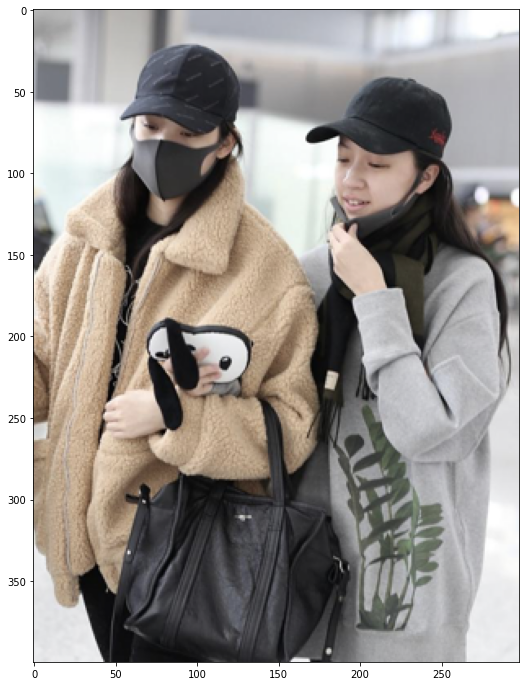

In [ ]:
#reading an sample image from the dataset 
img = cv2.imread(os.path.join(image_dir,'maksssksksss459.png'))
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)   #converting it from RGB to BGR
plt.figure(figsize=(12,12))                         #specifying the size of image to be printed
plt.imshow(out_img)                                # printing the image

In [ ]:
#printing the annotations file of the above image
# tree = lxml.etree.parse("/content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/annotations/maksssksksss244.xml")
tree = lxml.etree.parse(os.path.join(annot_dir,'maksssksksss459.xml'))

pretty = lxml.etree.tostring(tree, encoding="unicode", pretty_print=True)
print(pretty)

<annotation>
    <folder>images</folder>
    <filename>maksssksksss459.png</filename>
    <size>
        <width>298</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>60</xmin>
            <ymin>67</ymin>
            <xmax>115</xmax>
            <ymax>117</ymax>
        </bndbox>
    </object>
    <object>
        <name>mask_weared_incorrect</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>77</ymin>
            <xmax>239</xmax>
            <ymax>134</ymax>
        </bndbox>
    </object>
</annotation>



with_mask
mask_weared_incorrect


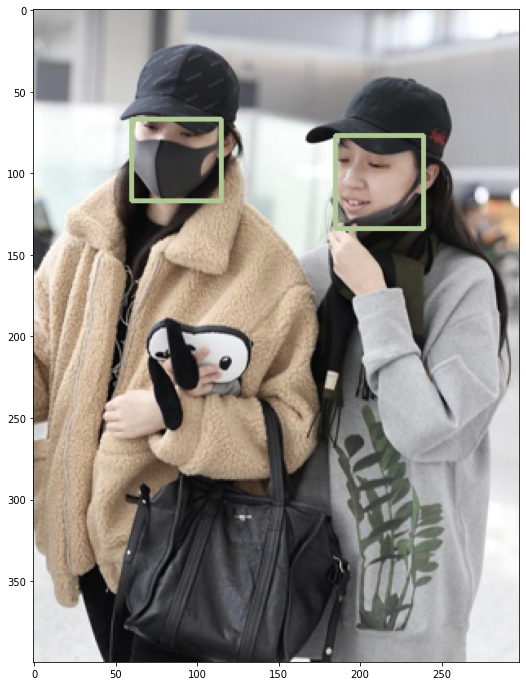

In [ ]:
# this function helps to extract the coordinates of the rectangles that bound the faces in these images
labels=[]
def face_extraction(directory_load_image,directory_load_notation):
   #opening the annotations file in readable format so that useful data can be extracted from it
        with open(os.path.join(directory_load_notation,"maksssksksss459.xml" ), 'r') as f:
            data = f.read()


            #getting data
            ann_dict=xmltodict.parse(data)["annotation"]
            object_list = ann_dict["object"]
            file="maksssksksss459.xml"


            #checking if there are more than 1 face in this image
            if isinstance(object_list, list): #if yes: itrating through them 
                 for object_ in object_list:
                        #getting face boundaries
                        xmin = int(object_["bndbox"]["xmin"])
                        xmax = int(object_["bndbox"]["xmax"])
                        ymin = int(object_["bndbox"]["ymin"])
                        ymax = int(object_["bndbox"]["ymax"])
                        
                        cv2.rectangle(out_img,(xmin,ymin),(xmax,ymax),(175,200,150),2)#printing a rectangle around the face
                        labels.append(object_["name"])
        #printing the  new image
        
        plt.figure(figsize=(12,12))
        plt.imshow(out_img)   
        return labels
# executing the function  
labels=face_extraction(image_dir,annot_dir)

for labels in labels:
    print(labels)

In [ ]:
def face_extraction(directory_load_image,directory_load_notation):
    labels = []
     
    for file in os.listdir(directory_load_notation):
        with open(os.path.join(directory_load_notation, file), 'r') as f:
            data = f.read()


            #getting data
            ann_dict=xmltodict.parse(data)["annotation"]
            object_list = ann_dict["object"]


            #checking if there are more than 1 face in this image
            if isinstance(object_list, list): #if yes: itrating through them 
                 for object_ in object_list:
                        #getting face boundaries
                        xmin = int(object_["bndbox"]["xmin"])
                        xmax = int(object_["bndbox"]["xmax"])
                        ymin = int(object_["bndbox"]["ymin"])
                        ymax = int(object_["bndbox"]["ymax"])
                        
                        labels.append(object_["name"])
                            
            else:
                #same thing on images with one face in them
                object_ = object_list
                xmin = int(object_["bndbox"]["xmin"])
                xmax = int(object_["bndbox"]["xmax"])
                ymin = int(object_["bndbox"]["ymin"])
                ymax = int(object_["bndbox"]["ymax"])

                labels.append(object_["name"])
               
                
    labels = np.asarray(labels)
    
    return labels
labels=face_extraction(image_dir,annot_dir)
print(labels.shape)
print(collections.Counter(labels))


(4072,)
Counter({'with_mask': 3232, 'without_mask': 717, 'mask_weared_incorrect': 123})


In [ ]:
labels.shape

(4072,)

In [ ]:
# this is a similar function 
#it helps to extract the cropped images of the faces of people in the images
# we will later pass these cropped images to the model for training it
def face_extraction(directory_load_image,directory_load_notation):
        faces=[] #this will store the cropped images
        labels=[]
   
        with open(os.path.join(directory_load_notation,"maksssksksss459.xml" ), 'r') as f:
            data = f.read()


            #getting data
            ann_dict=xmltodict.parse(data)["annotation"]
            object_list = ann_dict["object"]
            file="maksssksksss459.xml"

            #opening image
            image_name = file.replace("xml","png")
            
            im = Image.open(directory_load_image+image_name)

            #checking if there are more than 1 face in this image
            if isinstance(object_list, list): #if yes: itrating through them 
                 for object_ in object_list:
                        #getting face boundaries
                        xmin = int(object_["bndbox"]["xmin"])
                        xmax = int(object_["bndbox"]["xmax"])
                        ymin = int(object_["bndbox"]["ymin"])
                        ymax = int(object_["bndbox"]["ymax"])
                        crop_rectangle = (xmin, ymin, xmax , ymax) 
                        cropped_im = im.crop(crop_rectangle)  # cropping faces from the given image
                        faces.append(cropped_im)              # saving cropped images in the list
                        labels.append(object_["name"])
        return faces,labels

# executing the function      
faces,labels=face_extraction(image_dir,annot_dir)


with_mask


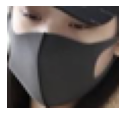

In [ ]:
#printing the 1st image
plt.figure(figsize=(2,2)) 
plt.imshow(faces[0])  
plt.axis('off')
print(labels[0]) 

mask_weared_incorrect


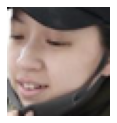

In [ ]:
#printing the 1st image
plt.figure(figsize=(2,2)) 
plt.imshow(faces[1])  
plt.axis('off')
print(labels[1]) 

# Data pre-processing


In [ ]:
# this function saves the cropped images of faces in two folders(train_images and test_images)
# it also saves the labels("with_mask" or "without_mask") of these cropped images in two lists y_train and y_test
# we are splitting our data in to train and test. one for training our model and other for testing our model
# it will also resize our images to (100,100) as all images are of different sizes so to maintain uniformity in our data it will resize the images
def cropping_images(directory_load_image,directory_load_notation,directory_save_train,directory_save_test):
    y_train = []
    y_test = []
    i=1
    
    if not os.path.exists(directory_save_train):
        os.makedirs(directory_save_train)
    if not os.path.exists(directory_save_test):
        os.makedirs(directory_save_test)
    
    for file in os.listdir(directory_load_notation):
        with open(os.path.join(directory_load_notation, file), 'r') as f:
            data = f.read()


            #getting data
            ann_dict=xmltodict.parse(data)["annotation"]
            object_list = ann_dict["object"]


            #opening image
            image_name = file.replace("xml","png")
            im = Image.open(directory_load_image+image_name)

            #checking if there are more than 1 face in this image
            if isinstance(object_list, list): #if yes: itrating through them 
                 for object_ in object_list:
                        #getting face boundaries
                        xmin = int(object_["bndbox"]["xmin"])
                        xmax = int(object_["bndbox"]["xmax"])
                        ymin = int(object_["bndbox"]["ymin"])
                        ymax = int(object_["bndbox"]["ymax"])
                        
                        #cropping the face and saving it
                        crop_rectangle = (xmin, ymin, xmax , ymax)
                        cropped_im = im.crop(crop_rectangle)
                        resized_im = cropped_im.resize((100,100), Image.ANTIALIAS)
                        
                        #this part is for sperating train set from test set
                        if i<3000:
                            resized_im.save(directory_save_train+str(i)+".png")
                            y_train.append(object_["name"])
                        else:
                            resized_im.save(directory_save_test+str(i-2999)+".png")
                            y_test.append(object_["name"])

                        i+=1
            else:
                #same thing on images with one face in them
                object_ = object_list
                xmin = int(object_["bndbox"]["xmin"])
                xmax = int(object_["bndbox"]["xmax"])
                ymin = int(object_["bndbox"]["ymin"])
                ymax = int(object_["bndbox"]["ymax"])

                crop_rectangle = (xmin, ymin, xmax , ymax)
                cropped_im = im.crop(crop_rectangle)
                resized_im = cropped_im.resize((100, 100), Image.ANTIALIAS)
                if i<3000:
                    resized_im.save(directory_save_train+str(i)+".png")
                    y_train.append(object_["name"])
                else:
                    resized_im.save(directory_save_test+str(i-2999)+".png")
                    y_test.append(object_["name"])

                i+=1
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return y_train,y_test

In [ ]:
# executing the previous function
y_train,y_test = cropping_images(image_dir,annot_dir,train_dir,test_dir)


In [ ]:
# it will count the number of items in our list
print(collections.Counter(y_train))
print(collections.Counter(y_test))

Counter({'with_mask': 2347, 'without_mask': 560, 'mask_weared_incorrect': 92})
Counter({'with_mask': 885, 'without_mask': 157, 'mask_weared_incorrect': 31})


In [ ]:
# we can not pass images directly to our model so here we will convert our images into  numpy arrays
def images_to_array(directory,num_img):
    X_nn=[]
    #iterating through directory and turning 100x100 images to an array with shape of (100,100,3) and stacking them inside a dataset.
    for i in range(1,num_img+1):
        im = Image.open(directory+str(i)+".png")
        rgb_im = im.convert('RGB')
        im = np.asarray(rgb_im,dtype="int")
        X_nn.append(im)
    return np.asarray(X_nn)

In [ ]:
#executing the previous function
X_train = images_to_array(train_dir,2999)
X_test = images_to_array(test_dir,1073)


#printing the shape of our saved data
print('Train dataset shape:',X_train.shape)

print('Test dataset shape:',X_test.shape)

#it will print (3599, 100, 100, 3)
#here 3599 is the number of images in X_train
# 100x100 is the size of image
# 3 is the number of colour channels (RGB - RED GREEN BLUE)


Train dataset shape: (2999, 100, 100, 3)
Test dataset shape: (1073, 100, 100, 3)


**SMOTE ANALYSIS**

In [ ]:
## Applying SMOTE Analysis
from imblearn.over_sampling import SMOTE 

sm = SMOTE()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
X_sm, y_sm = sm.fit_sample(X_train.reshape(X_train.shape[0], -1), y_train) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_sm=X_sm.reshape(X_sm.shape[0], 100, 100, 3) 

In [ ]:
# Reassigning the varaibles back
X_train=X_sm
y_train=y_sm

In [ ]:
print(collections.Counter(y_train))

Counter({'without_mask': 2347, 'with_mask': 2347, 'mask_weared_incorrect': 2347})


In [ ]:
# so now we have arrays of images and their labels
# example
print("label= ",y_train[0]) # this prints the label of first image
print()
print("Array = ",X_train[0]) #this prints the numpy array of first image

label=  without_mask

Array =  [[[ 13  15  15]
  [ 16  17  17]
  [ 20  19  19]
  ...
  [ 99  98  93]
  [100  98  93]
  [100  98  94]]

 [[ 15  17  17]
  [ 18  19  19]
  [ 22  21  21]
  ...
  [100  98  93]
  [100  98  93]
  [100  98  94]]

 [[ 17  19  19]
  [ 20  21  22]
  [ 25  23  23]
  ...
  [101  98  93]
  [100  98  93]
  [100  98  94]]

 ...

 [[192 194 185]
  [189 192 184]
  [186 189 183]
  ...
  [167 127 106]
  [169 129 108]
  [170 130 109]]

 [[173 176 169]
  [173 176 172]
  [174 177 174]
  ...
  [169 129 108]
  [171 131 110]
  [172 132 111]]

 [[161 164 159]
  [163 166 164]
  [166 169 168]
  ...
  [170 130 110]
  [173 133 112]
  [174 134 113]]]


In [ ]:
def preproccesing(X_train,X_test,y_train,y_test):
    #nomalizing color values
    X_train = X_train / 255
    X_test = X_test / 255
    
    #categorical to numerical values for labels.
    conditions = [
                    (y_train == "without_mask"),
                    y_train == ("mask_weared_incorrect"),
                    (y_train == "with_mask")]
    choices = [0, 1, 2]
    y_train = np.select(conditions, choices)
    conditions = [
                    (y_test == "without_mask"),
                    y_test == ("mask_weared_incorrect"),
                    (y_test == "with_mask")]
    choices = [0, 1, 2]
    y_test = np.select(conditions, choices)
    return X_train,X_test,y_train,y_test

In [ ]:
#executing the function
X_train,X_test,y_train,y_test = preproccesing(X_train,X_test,y_train,y_test)

In [ ]:
collections.Counter(y_train)

Counter({0: 2347, 1: 2347, 2: 2347})

In [ ]:
collections.Counter(y_test)

Counter({0: 157, 1: 31, 2: 885})

****So now we have the two training and 2 testing arrays of images and labels****
- X_train : Train array for images
- y_train : Train array for labels

- X_test  : Test array for images 
- y_test : Test array for labels

In [ ]:
print('X_TEST:  ' + str(len(X_test)))
print('Y_TEST:  '+ str(len(y_test)))
print('X_TRAIN: ' + str(len(X_train)))
print('Y_TRAIN: ' + str(len(y_train)))

X_TEST:  1073
Y_TEST:  1073
X_TRAIN: 7041
Y_TRAIN: 7041


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7041, 100, 100, 3)
(1073, 100, 100, 3)
(7041,)
(1073,)


## ResNet Model

In [ ]:
# Original One
datagen = ImageDataGenerator(
        rotation_range=40,          # rotate the image 40 degrees
        width_shift_range = 0.2,    # Shift the pic width by a max of 20%
        height_shift_range = 0.2,   # Shift the pic height by a max of 20%
        shear_range = 0.2,          # Shear means cutting away part of the image (max 20%)
        zoom_range = 0.2,           # Zoom  the image in by 20% max
        horizontal_flip = True,     # Flipping the image  horizontally 
        fill_mode = "nearest"       # Fill in missing pixels with the nearest filled value
    )

datagen.fit(X_train) 

In [ ]:
def create_model(base_model):
    base_model.trainable = True
    global_average_layer = GlobalAveragePooling2D()(base_model.output)
    prediction_layer=Dense(3,activation='softmax')(global_average_layer) 
    model = Model(inputs=base_model.input, outputs=prediction_layer)
    opt=Adam(learning_rate=learning_rate,decay=learning_rate/epochs)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model


def fit_model(model): 
    history = model.fit(
                        datagen.flow(X_train,y_train,batch_size=batch_size,),
                        batch_size=batch_size,
                        steps_per_epoch=len(X_train)//batch_size,
                        epochs=epochs,
                        validation_data=(X_test,y_test),
                        validation_steps=len(X_test)//batch_size
                        )
    return history



# PLOT LOSS AND ACCURACY
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()



In [ ]:
learning_rate=0.0001
epochs=50
batch_size=30


In [ ]:
IMG_SHAPE = (100, 100, 3)
base_model1 = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model2 = Xception(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model3 = ResNet50V2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
model1 = create_model(base_model1)
model2 = create_model(base_model2)
model3 = create_model(base_model3)

In [ ]:
# Mobile Net
history1 = fit_model(model1)

Epoch 1/50
234/234 [==============================] - 35s 72ms/step - loss: 0.4009 - accuracy: 0.8404 - val_loss: 0.9403 - val_accuracy: 0.6914
Epoch 2/50
234/234 [==============================] - 16s 69ms/step - loss: 0.1935 - accuracy: 0.9303 - val_loss: 0.5098 - val_accuracy: 0.8038
Epoch 3/50
234/234 [==============================] - 16s 69ms/step - loss: 0.1558 - accuracy: 0.9439 - val_loss: 0.6213 - val_accuracy: 0.7695
Epoch 4/50
234/234 [==============================] - 16s 69ms/step - loss: 0.1192 - accuracy: 0.9609 - val_loss: 0.3537 - val_accuracy: 0.8638
Epoch 5/50
234/234 [==============================] - 16s 69ms/step - loss: 0.0838 - accuracy: 0.9712 - val_loss: 0.9945 - val_accuracy: 0.7352
Epoch 6/50
234/234 [==============================] - 16s 68ms/step - loss: 0.0905 - accuracy: 0.9692 - val_loss: 0.2900 - val_accuracy: 0.9143
Epoch 7/50
234/234 [==============================] - 16s 70ms/step - loss: 0.0776 - accuracy: 0.9742 - val_loss: 0.3467 - val_accuracy:

In [ ]:
# Xception Net
history2 = fit_model(model2)

Epoch 1/50
234/234 [==============================] - 24s 86ms/step - loss: 0.4009 - accuracy: 0.8514 - val_loss: 0.2822 - val_accuracy: 0.9124
Epoch 2/50
234/234 [==============================] - 19s 81ms/step - loss: 0.1309 - accuracy: 0.9575 - val_loss: 0.1352 - val_accuracy: 0.9657
Epoch 3/50
234/234 [==============================] - 19s 81ms/step - loss: 0.0900 - accuracy: 0.9693 - val_loss: 0.1196 - val_accuracy: 0.9648
Epoch 4/50
234/234 [==============================] - 19s 81ms/step - loss: 0.0616 - accuracy: 0.9809 - val_loss: 0.1206 - val_accuracy: 0.9648
Epoch 5/50
234/234 [==============================] - 19s 81ms/step - loss: 0.0521 - accuracy: 0.9843 - val_loss: 0.1288 - val_accuracy: 0.9629
Epoch 6/50
234/234 [==============================] - 19s 81ms/step - loss: 0.0385 - accuracy: 0.9862 - val_loss: 0.1423 - val_accuracy: 0.9667
Epoch 7/50
234/234 [==============================] - 19s 81ms/step - loss: 0.0359 - accuracy: 0.9877 - val_loss: 0.1509 - val_accuracy:

In [ ]:
# ResNet
history3 = fit_model(model3)

Epoch 1/50
234/234 [==============================] - 22s 76ms/step - loss: 0.3562 - accuracy: 0.8605 - val_loss: 0.3636 - val_accuracy: 0.8971
Epoch 2/50
234/234 [==============================] - 17s 72ms/step - loss: 0.1655 - accuracy: 0.9422 - val_loss: 0.1366 - val_accuracy: 0.9610
Epoch 3/50
234/234 [==============================] - 17s 73ms/step - loss: 0.1277 - accuracy: 0.9524 - val_loss: 0.1658 - val_accuracy: 0.9581
Epoch 4/50
234/234 [==============================] - 17s 72ms/step - loss: 0.0854 - accuracy: 0.9692 - val_loss: 0.2082 - val_accuracy: 0.9505
Epoch 5/50
234/234 [==============================] - 17s 72ms/step - loss: 0.0752 - accuracy: 0.9743 - val_loss: 0.2171 - val_accuracy: 0.9457
Epoch 6/50
234/234 [==============================] - 17s 72ms/step - loss: 0.0709 - accuracy: 0.9755 - val_loss: 0.1561 - val_accuracy: 0.9610
Epoch 7/50
234/234 [==============================] - 17s 72ms/step - loss: 0.0601 - accuracy: 0.9777 - val_loss: 0.1395 - val_accuracy:

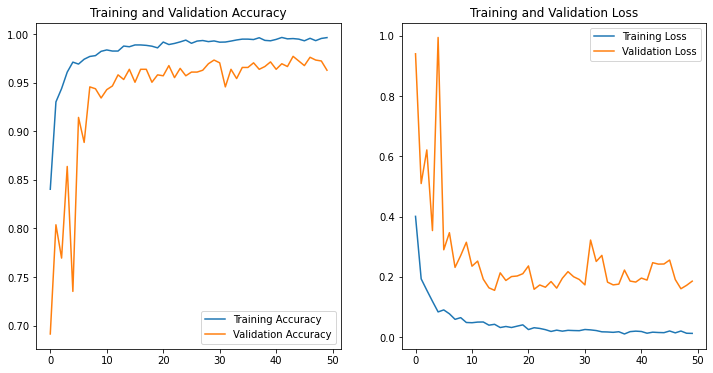

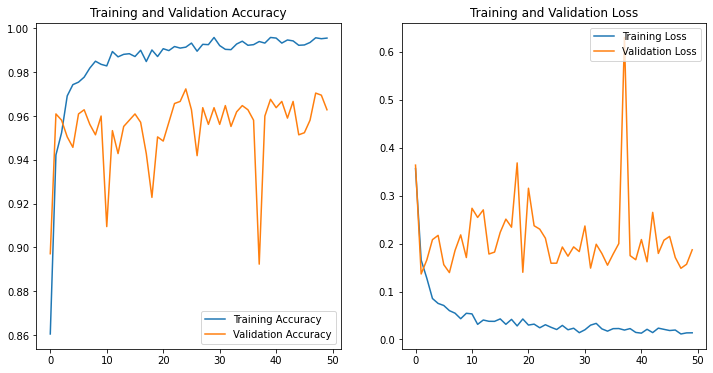

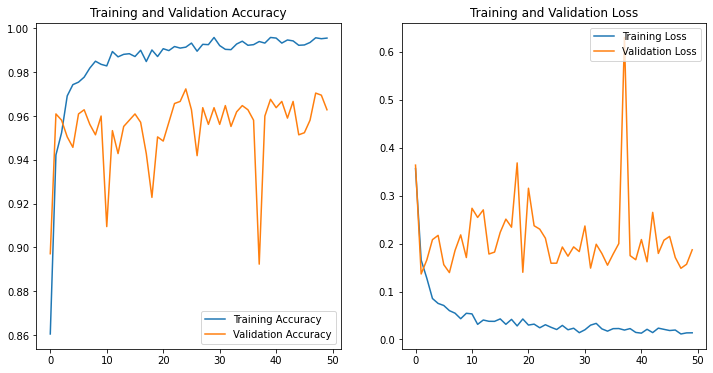

In [ ]:
# New run check
plot_history(history1)
plot_history(history3)
plot_history(history3)

In [ ]:
def evaluatuion (model,X_test,y_test):
    #getting models predcitons on test set
    y_pred = []
    y_prob = model.predict(X_test)
    for i in y_prob:
        y_pred.append(np.argmax(i))
           
    confusion_matrix_array = confusion_matrix(y_test,y_pred)

    print("simple confusion matrix")
    print(confusion_matrix_array)
    print("\nReport:")
    print(classification_report(y_test, y_pred,
	  target_names=["without mask","mask weared incorrectly","with mask"]))
    
    confusion_matrix_array = confusion_matrix(y_test,y_pred)
    plt.title('\nConfusion Matrix')
    g= sns.heatmap(confusion_matrix_array, annot=True,yticklabels=["Act No Mask","Act mask weared incorrectly","Act with mask"],xticklabels=["Pred No Mask","Pred mask weared incorrectly","Pred with mask"], fmt='g', cmap=plt.cm.Blues,square = True,linewidths=.5)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    

    return y_pred

simple confusion matrix
[[149   1   7]
 [  6  18   7]
 [  8  11 866]]

Report:
                         precision    recall  f1-score   support

           without mask       0.91      0.95      0.93       157
mask weared incorrectly       0.60      0.58      0.59        31
              with mask       0.98      0.98      0.98       885

               accuracy                           0.96      1073
              macro avg       0.83      0.84      0.83      1073
           weighted avg       0.96      0.96      0.96      1073



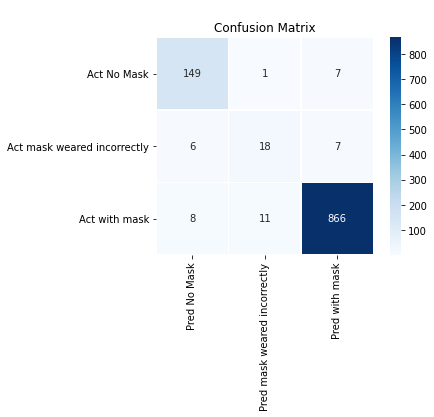

In [ ]:
y1=evaluatuion (model1,X_test,y_test)

simple confusion matrix
[[149   2   6]
 [  2  18  11]
 [  4   4 877]]

Report:
                         precision    recall  f1-score   support

           without mask       0.96      0.95      0.96       157
mask weared incorrectly       0.75      0.58      0.65        31
              with mask       0.98      0.99      0.99       885

               accuracy                           0.97      1073
              macro avg       0.90      0.84      0.87      1073
           weighted avg       0.97      0.97      0.97      1073



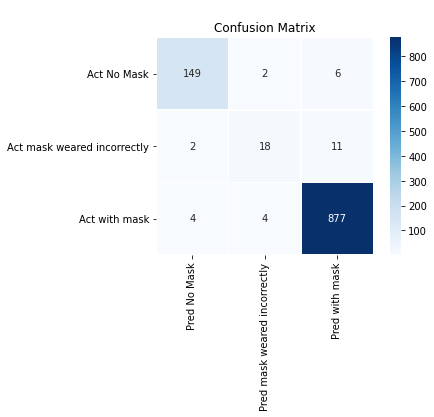

In [ ]:
y2=evaluatuion (model2,X_test,y_test)

simple confusion matrix
[[138   3  16]
 [  5  17   9]
 [  6   0 879]]

Report:
                         precision    recall  f1-score   support

           without mask       0.93      0.88      0.90       157
mask weared incorrectly       0.85      0.55      0.67        31
              with mask       0.97      0.99      0.98       885

               accuracy                           0.96      1073
              macro avg       0.92      0.81      0.85      1073
           weighted avg       0.96      0.96      0.96      1073



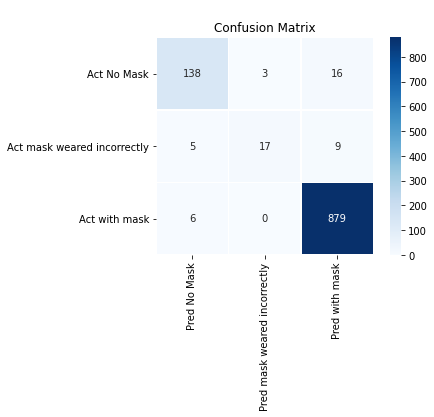

In [ ]:
y3=evaluatuion (model3,X_test,y_test)

In [ ]:
model1.save(os.path.join(modelpath,"BASE_MODEL1.h5"))
model2.save(os.path.join(modelpath,"BASE_MODEL2.h5"))
model3.save(os.path.join(modelpath,"BASE_MODEL3.h5"))

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
def load_all_models():
    all_models = []
    model_names = ['BASE_MODEL1.h5', 'BASE_MODEL2.h5','BASE_MODEL3.h5']
    for model_name in model_names:
        filename = os.path.join(modelpath, model_name)
        model = load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models

In [ ]:
models = load_all_models()

loaded: /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/saved_models/BASE_MODEL1.h5
loaded: /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/saved_models/BASE_MODEL2.h5
loaded: /content/drive/MyDrive/Deep_Learning/Face_Mask_Detection/FaceMaskDetectionDataset/saved_models/BASE_MODEL3.h5


In [ ]:

def ensemble_model(models):
    for i, model in enumerate(models):
        for layer in model.layers:
            layer.trainable = False
    ensemble_visible = [model.input for model in models]
    ensemble_outputs = [model.output for model in models]
    merge = concatenate(ensemble_outputs)

    merge = Flatten()(merge)
    merge = Dense(units=256, activation='relu')(merge)
    merge = Dropout(rate=0.25)(merge)
    merge=Dense(128,activation='relu', name='Classify')(merge)

    output=Dense(3,activation='softmax')(merge) 

    model = Model(inputs=ensemble_visible, outputs=output)
    opt=Adam(learning_rate=learning_rate,decay=learning_rate/epochs)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


    return model


In [ ]:
model = ensemble_model(models)

In [ ]:
X = [X_train for _ in range(len(model.input))]
X_1 = [X_test for _ in range(len(model.input))]

In [ ]:

history = model.fit(X, y_train,
                    batch_size=batch_size,
                    steps_per_epoch=len(X_train)//batch_size,
                    epochs=epochs,
                    validation_data=(X_1, y_test),
                   validation_steps=len(X_test)//batch_size
                    )

Epoch 1/50
234/234 [==============================] - 22s 63ms/step - loss: 0.4548 - accuracy: 0.9701 - val_loss: 0.1394 - val_accuracy: 0.9781
Epoch 2/50
234/234 [==============================] - 12s 53ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.0946 - val_accuracy: 0.9781
Epoch 3/50
234/234 [==============================] - 13s 54ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0989 - val_accuracy: 0.9781
Epoch 4/50
234/234 [==============================] - 12s 53ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1056 - val_accuracy: 0.9790
Epoch 5/50
234/234 [==============================] - 12s 53ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1117 - val_accuracy: 0.9790
Epoch 6/50
234/234 [==============================] - 12s 53ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1180 - val_accuracy: 0.9781
Epoch 7/50
234/234 [==============================] - 12s 53ms/step - loss: 7.3310e-04 - accuracy: 1.0000 - val_loss: 0.1234 - val_accur

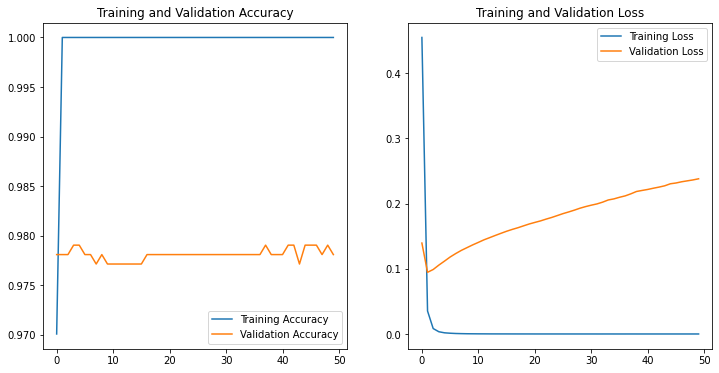

In [ ]:
plot_history(history)

In [ ]:

print('MobileNetV2 acc:', history1.history['val_accuracy'][-1])
print('Xception acc:', history2.history['val_accuracy'][-1])
print('Resnet acc:', history3.history['val_accuracy'][-1])
print('Ensemble acc:', history.history['val_accuracy'][-1])


MobileNetV2 acc: 0.9628571271896362
Xception acc: 0.9723809361457825
Resnet acc: 0.9628571271896362
Ensemble acc: 0.9780952334403992


simple confusion matrix
[[151   1   5]
 [  5  19   7]
 [  4   1 880]]

Report:
                         precision    recall  f1-score   support

           without mask       0.94      0.96      0.95       157
mask weared incorrectly       0.90      0.61      0.73        31
              with mask       0.99      0.99      0.99       885

               accuracy                           0.98      1073
              macro avg       0.95      0.86      0.89      1073
           weighted avg       0.98      0.98      0.98      1073



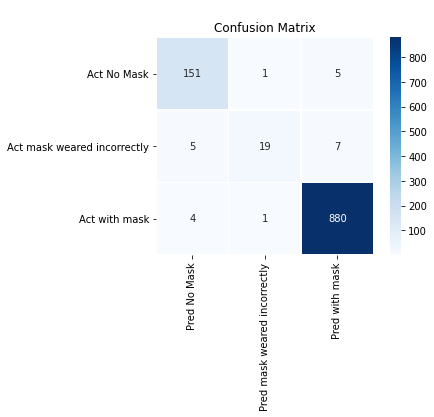

In [ ]:
y=evaluatuion (model,X_1,y_test)

**Evaluation Matrix - Hybrid Dataset**

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns

def evaluatation_metrics(y_true, y_pred,model):

    accuracy = accuracy_score(y_true, y_pred)
    #roc_auc = roc_auc_score(y_true, y_pred, average='weighted',multi_class='ovr')
    cm = confusion_matrix(y_true, y_pred)

    confusion_matrix_array = confusion_matrix(y_true, y_pred)

    print("simple confusion matrix")
    print(confusion_matrix_array)
    print("\nReport:")
    print(classification_report(y_true, y_pred,
	  target_names=["without mask","mask weared incorrectly","with mask"]))
    
    confusion_matrix_array = confusion_matrix(y_true, y_pred)
    plt.title('\nConfusion Matrix')
    g= sns.heatmap(confusion_matrix_array, annot=True,yticklabels=["Act No Mask","Act mask weared incorrectly","Act with mask"],xticklabels=["Pred No Mask","Pred mask weared incorrectly","Pred with mask"], fmt='g', cmap=plt.cm.Blues,square = True,linewidths=.5)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    plt.show()



**Trying Hybrid model for ResNet**

In [ ]:
for i, model in enumerate(models):
      for layer in model.layers:
          layer.trainable = False
      ensemble_visible = [model.input for model in models]
      ensemble_outputs = [model.output for model in models]
      merge = concatenate(ensemble_outputs)

      #merge=Dense(256,activation='relu')(merge)
      merge = Flatten()(merge)
      merge = Dense(units=256, activation='relu')(merge)
      merge = Dropout(rate=0.25)(merge)
      merge=Dense(128,activation='relu', name='Classify')(merge)
      #merge=Flatten()(merge) 
      #merge=Dense(128,activation='relu', name='Classify')(merge)
      #merge=Dropout(0.3)(merge)
      #merge=Dense(128,activation='relu', name='Classify')(merge)
      
      output=Dense(3,activation='softmax')(merge) 
      model_ML = Model(inputs=ensemble_visible, outputs=output)

In [ ]:
model_ML.summary()

Model: "model_155"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 52, 52, 64)   0           conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
model_feat_R = Model(inputs=ensemble_visible,outputs=model_ML.get_layer('Classify').output)

In [ ]:
X = [X_train for _ in range(len(model_ML.input))]
X_1 = [X_test for _ in range(len(model_ML.input))]

In [ ]:
feat_train_R = model_feat_R.predict(X)
print(feat_train_R.shape)

(7041, 128)


In [ ]:
feat_val_R = model_feat_R.predict(X_1)
print(feat_val_R.shape)

(1073, 128)


**Applying SVM**

In [ ]:
#svm = SVC(kernel='rbf')

svm = SVC(kernel='rbf', random_state=42, gamma=0.001, C=1)
svm.fit(feat_train_R,y_train)

print('fitting done !!!')

fitting done !!!


***Evaluation Matrix -Testing dataset***

In [ ]:
matrix = confusion_matrix(y_test,svm.predict(feat_val_R))
print('SVM --> Validation Set Confusion Matrix')
print(matrix)

SVM --> Validation Set Confusion Matrix
[[150   2   5]
 [  2  22   7]
 [  3   2 880]]


In [ ]:
svm.score(feat_val_R,y_test)

0.9804287045666356

simple confusion matrix
[[150   2   5]
 [  2  22   7]
 [  3   2 880]]

Report:
                         precision    recall  f1-score   support

           without mask       0.97      0.96      0.96       157
mask weared incorrectly       0.85      0.71      0.77        31
              with mask       0.99      0.99      0.99       885

               accuracy                           0.98      1073
              macro avg       0.93      0.89      0.91      1073
           weighted avg       0.98      0.98      0.98      1073



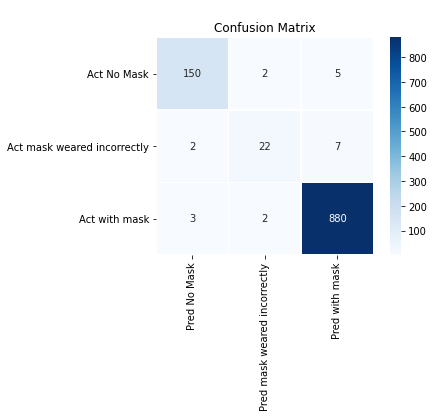

In [ ]:
evaluatation_metrics(y_test,svm.predict(feat_val_R), "DHL: Resnet + SVM Model - Testing Dataset")

***Evaluation Matrix - Training Dataset***


In [ ]:
matrix = confusion_matrix(y_train,svm.predict(feat_train_R))
print('SVM --> Validation Set Confusion Matrix')
print(matrix)

SVM --> Validation Set Confusion Matrix
[[2346    1    0]
 [   0 2347    0]
 [   0    0 2347]]


In [ ]:
svm.score(feat_train_R,y_train)

0.9998579747195001

simple confusion matrix
[[2346    1    0]
 [   0 2347    0]
 [   0    0 2347]]

Report:
                         precision    recall  f1-score   support

           without mask       1.00      1.00      1.00      2347
mask weared incorrectly       1.00      1.00      1.00      2347
              with mask       1.00      1.00      1.00      2347

               accuracy                           1.00      7041
              macro avg       1.00      1.00      1.00      7041
           weighted avg       1.00      1.00      1.00      7041



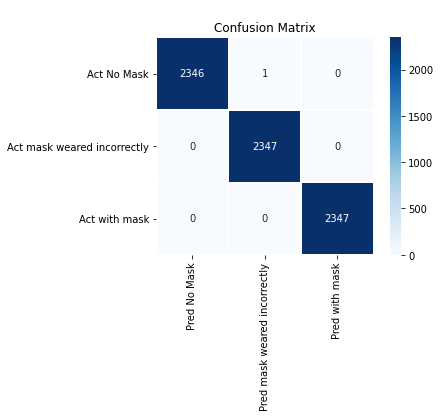

In [ ]:
evaluatation_metrics(y_train,svm.predict(feat_train_R), "DHL: Resnet + SVM Model - Training Dataset")

**Applying XGB**

In [ ]:
xb = xgb.XGBClassifier(learning_rate=0.01,  
                      subsample = 0.33,
                      n_estimators=1000, 
                      #reg_alpha = 0.3,
                      #objective="multi:softprob",
                      max_depth=4)

In [ ]:
#xb = xgb.XGBClassifier(learning_rate=0.01,max_depth=4, 
                      #gamma=0.01)
#xb = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
#xb = xgb.XGBClassifier()
xb.fit(feat_train_R,y_train)

print('fitting done !!!')

fitting done !!!


***Evaluation Matrix -Testing dataset***

In [ ]:
matrix = confusion_matrix(y_test,xb.predict(feat_val_R))
print('XGboost --> Testing Set Confusion Matrix')
print(matrix)

XGboost --> Testing Set Confusion Matrix
[[153   1   3]
 [  3  20   8]
 [ 11   1 873]]


simple confusion matrix
[[153   1   3]
 [  3  20   8]
 [ 11   1 873]]

Report:
                         precision    recall  f1-score   support

           without mask       0.92      0.97      0.94       157
mask weared incorrectly       0.91      0.65      0.75        31
              with mask       0.99      0.99      0.99       885

               accuracy                           0.97      1073
              macro avg       0.94      0.87      0.90      1073
           weighted avg       0.97      0.97      0.97      1073



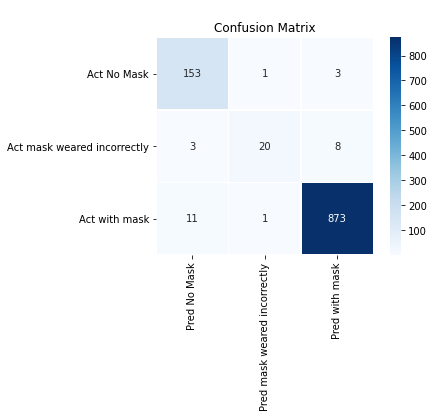

In [ ]:
# Testing Dataset
evaluatation_metrics(y_test,xb.predict(feat_val_R), "DHL: Resnet + XGBoost Model - Testing")

In [ ]:
xb.score(feat_val_R,y_test)

0.9748369058713886

***Evaluation Matrix - Training Dataset***

In [ ]:
matrix = confusion_matrix(y_train,xb.predict(feat_train_R))
print('XGboost --> Training Set Confusion Matrix')
print(matrix)

XGboost --> Training Set Confusion Matrix
[[2346    1    0]
 [   0 2347    0]
 [   0    0 2347]]


simple confusion matrix
[[2346    1    0]
 [   0 2347    0]
 [   0    0 2347]]

Report:
                         precision    recall  f1-score   support

           without mask       1.00      1.00      1.00      2347
mask weared incorrectly       1.00      1.00      1.00      2347
              with mask       1.00      1.00      1.00      2347

               accuracy                           1.00      7041
              macro avg       1.00      1.00      1.00      7041
           weighted avg       1.00      1.00      1.00      7041



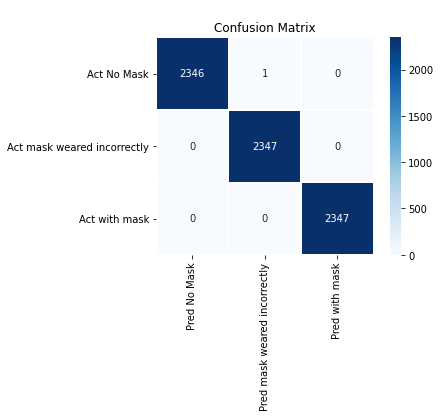

In [ ]:
evaluatation_metrics(y_train,xb.predict(feat_train_R), "DHL: Resnet + XGBoost Model - Training")

In [ ]:
xb.score(feat_train_R,y_train)

0.9998579747195001

**Applying Random Forest**

In [ ]:
clf = RandomForestClassifier(max_depth=4, random_state=0)

In [ ]:
clf.fit(feat_train_R,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

***Evaluation Matrix -Testing dataset***

In [ ]:
matrix = confusion_matrix(y_test,clf.predict(feat_val_R))
print('RF --> Validation Set Confusion Matrix')
print(matrix)

RF --> Validation Set Confusion Matrix
[[153   1   3]
 [  5  19   7]
 [  5   0 880]]


simple confusion matrix
[[153   1   3]
 [  5  19   7]
 [  5   0 880]]

Report:
                         precision    recall  f1-score   support

           without mask       0.94      0.97      0.96       157
mask weared incorrectly       0.95      0.61      0.75        31
              with mask       0.99      0.99      0.99       885

               accuracy                           0.98      1073
              macro avg       0.96      0.86      0.90      1073
           weighted avg       0.98      0.98      0.98      1073



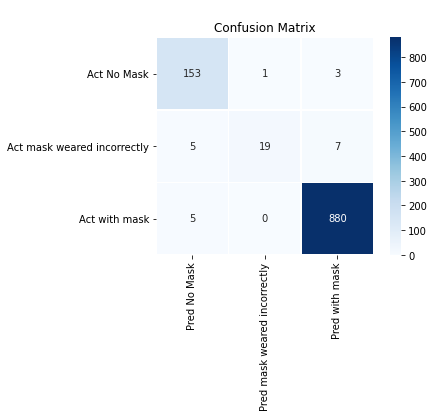

In [ ]:
evaluatation_metrics(y_test,clf.predict(feat_val_R), "DHL: Resnet + Random Forest Model - Testing")

In [ ]:
print('Random Forest Testing Accuracy')
clf.score(feat_val_R,y_test)

Random Forest Testing Accuracy


0.9804287045666356

***Evaluation Matrix -Training dataset***

In [ ]:
matrix = confusion_matrix(y_train,clf.predict(feat_train_R))
print('RandomForest --> Training Set Confusion Matrix')
print(matrix)

RandomForest --> Training Set Confusion Matrix
[[2347    0    0]
 [   0 2347    0]
 [   0    0 2347]]


simple confusion matrix
[[2347    0    0]
 [   0 2347    0]
 [   0    0 2347]]

Report:
                         precision    recall  f1-score   support

           without mask       1.00      1.00      1.00      2347
mask weared incorrectly       1.00      1.00      1.00      2347
              with mask       1.00      1.00      1.00      2347

               accuracy                           1.00      7041
              macro avg       1.00      1.00      1.00      7041
           weighted avg       1.00      1.00      1.00      7041



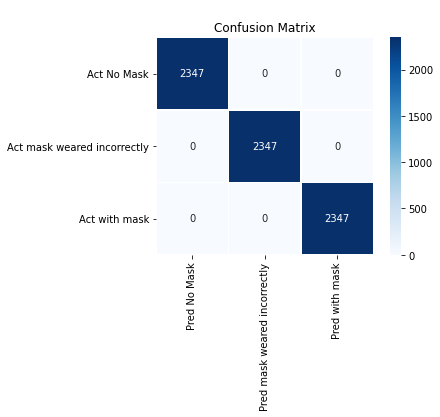

In [ ]:
evaluatation_metrics(y_train,clf.predict(feat_train_R), "DHL: Resnet + Random Forest Model - Training")

In [ ]:
print('Random Forest Training Accuracy')
clf.score(feat_train_R,y_train)

Random Forest Training Accuracy


1.0

**AdaBoost Classifier**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier 

In [ ]:
ad=AdaBoostClassifier(n_estimators=50,learning_rate=1)

In [ ]:
ad.fit(feat_train_R,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=50, random_state=None)

#### Evaluation Matrix - Testing Dataset

In [ ]:
matrix = confusion_matrix(y_test,ad.predict(feat_val_R))
print('RF --> Validation Set Confusion Matrix')
print(matrix)

RF --> Validation Set Confusion Matrix
[[153   1   3]
 [  5  19   7]
 [ 11   8 866]]


simple confusion matrix
[[153   1   3]
 [  5  19   7]
 [ 11   8 866]]

Report:
                         precision    recall  f1-score   support

           without mask       0.91      0.97      0.94       157
mask weared incorrectly       0.68      0.61      0.64        31
              with mask       0.99      0.98      0.98       885

               accuracy                           0.97      1073
              macro avg       0.86      0.86      0.86      1073
           weighted avg       0.97      0.97      0.97      1073



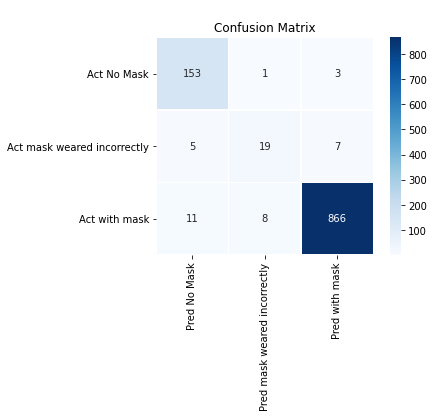

In [ ]:
evaluatation_metrics(y_test,ad.predict(feat_val_R), "DHL: Resnet + AdaBoost  Model - Testing")

In [ ]:
print('Random Forest Testing Accuracy')
ad.score(feat_val_R,y_test)

Random Forest Testing Accuracy


0.967381174277726

***Evaluation Matrix -Training dataset***

In [ ]:
matrix = confusion_matrix(y_train,ad.predict(feat_train_R))
print('AdaBoost --> Training Set Confusion Matrix')
print(matrix)

AdaBoost --> Training Set Confusion Matrix
[[2347    0    0]
 [   0 2347    0]
 [   0    0 2347]]


simple confusion matrix
[[2347    0    0]
 [   0 2347    0]
 [   0    0 2347]]

Report:
                         precision    recall  f1-score   support

           without mask       1.00      1.00      1.00      2347
mask weared incorrectly       1.00      1.00      1.00      2347
              with mask       1.00      1.00      1.00      2347

               accuracy                           1.00      7041
              macro avg       1.00      1.00      1.00      7041
           weighted avg       1.00      1.00      1.00      7041



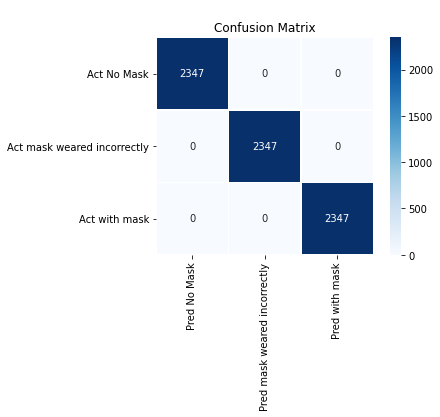

In [ ]:
evaluatation_metrics(y_train,ad.predict(feat_train_R), "DHL: Resnet + Ada Boost Model - Training")

In [ ]:
print('Ada Boost Training Accuracy')
clf.score(feat_train_R,y_train)

Ada Boost Training Accuracy


1.0